In [1]:
#Import basic modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import scipy.stats as stats
import math
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [2]:
#Import data
url = "https://raw.githubusercontent.com/arimitramaiti/datasets/master/articles/a5_data.csv"
dataset = pd.read_csv(url, error_bad_lines=False, header=0, index_col=None)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


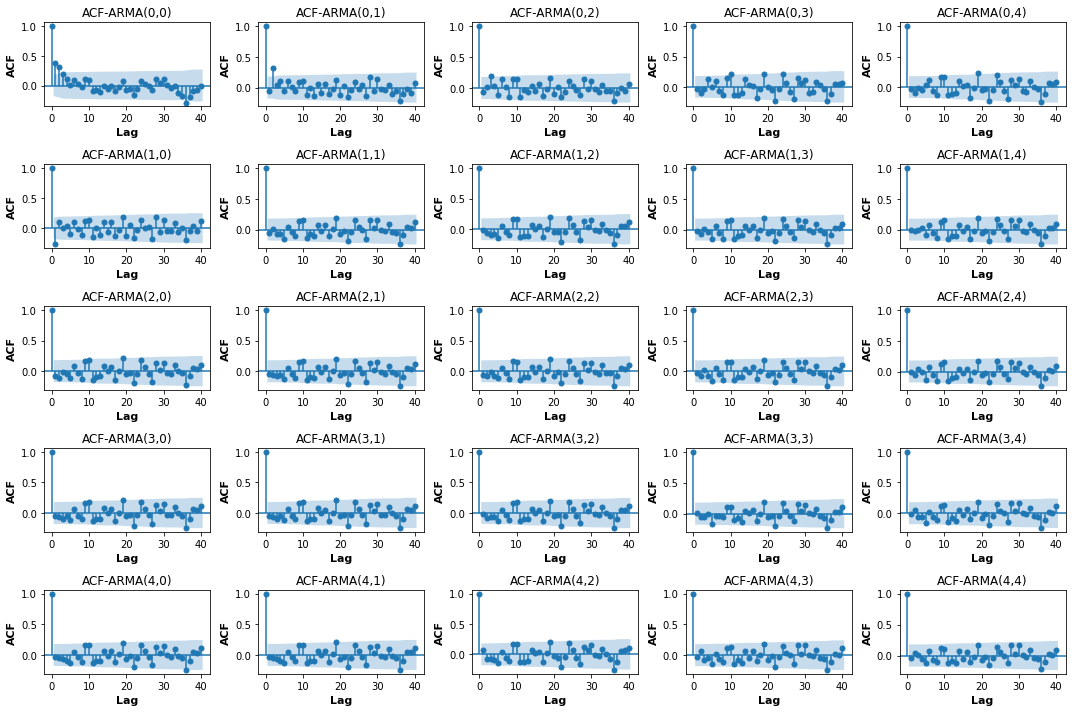

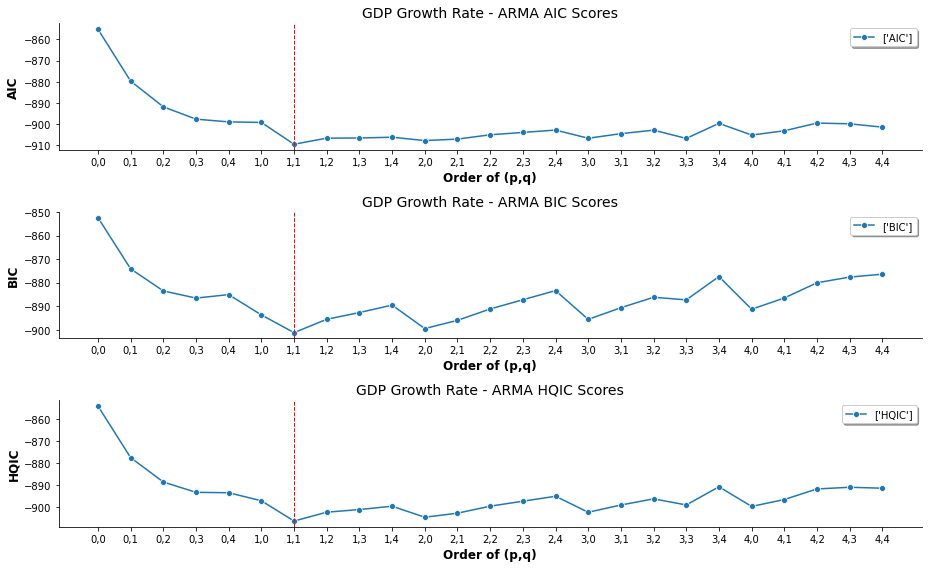

In [4]:
#Empty list to store model iteration results
store = []
#Empty list to store residuals of each iteration
res = []
#for each p ranging from 0 to 4, run q from 0 to 4
for i in range(5):
    for j in range(5):
        p = i
        d = 0
        q = j
        #model = ARIMA(dataset.GDP_GWR, order=(p,d,q))
        #Use SARIMAX, bacause ARIMA by default enforces invertibility
        model = sm.tsa.statespace.SARIMAX(dataset.GDP_GWR, order=(p,d,q), enforce_invertibility=False)
        ##Use Robust Standard errors for coefficient t-test, like stata, we can also use cluster in cov_kwds
        model_fit = model.fit(disp=0, transparams=False, solver="lbfgs", maxiter=1000, cov_type='robust')
        model_aic = model_fit.aic
        model_bic = model_fit.bic
        model_hqic = model_fit.hqic
        model_ll = model_fit.llf
        model_sigma = round(model_fit.params[-1],3)
        #total terms with the random shock like Stata, but does not include the constant term
        total_terms = p + q + 1
        signif_terms = sum(round(model_fit.pvalues,3)<0.10)
        ratio_terms = (signif_terms/total_terms)*100
        residuals = pd.DataFrame(model_fit.resid)
        store_list = [p, d, q, model_aic, model_bic, model_hqic, model_ll, model_sigma, total_terms, signif_terms, ratio_terms]
        res_list = [p, d, q, residuals]
        store.append(store_list)
        res.append(res_list)
        
        #Create collated iterations dataset
model_iteration = pd.DataFrame(store, columns=["p", "d", "q", "model_aic", "model_bic", "model_hqic", "model_ll", "model_sigma",
                                  "total_terms", "signif_terms", "ratio_terms"])

#Convert residual list as dataframe
res_df = pd.DataFrame(res)
#Create index for number of time points, there are 120 in total
create_index = np.linspace(0, 119, 120)
#Create a blank data frame
blank_df = pd.DataFrame(create_index)
#For each order of p,q, extract residuals and concatenate in a blank data frame
for i in range(len(res_df)):
    col = res_df.iloc[i, 3]
    blank_df = pd.concat([blank_df, col], axis=1)
#Remove dummy index
model_residuals = blank_df.iloc[ : , 1:]
#Create a text string to rename columns of residuals dataset
create_names = "ARMA(" + model_iteration.p.astype(str) + "," + model_iteration.q.astype(str) + ")"
#Rename columns
model_residuals.columns = create_names
#Remove some objects
del res_df, blank_df, create_names
#Create an order column to be used in plots later
model_iteration['Order'] = model_iteration.p.astype(str) + "," + model_iteration.q.astype(str)

#Create a 5 by 5 matrix diagram
fig, axes = plt.subplots(5, 5, figsize=(15,10))
#For each row of diagram, run through columns first, but calculate which column to extract
for i in range(5):
    for j in range(5):
        if i==0:
            k = j
        elif i==1:
            k = i+j+4
        elif i==2:
            k = i+j+8
        elif i==3:
            k = i+j+12
        elif i==4:
            k = i+j+16
        else:
            k = 0
        sm.graphics.tsa.plot_acf(model_residuals.iloc[ :, k].squeeze(), lags=40, ax=axes[i,j])
        axes[i,j].set_title("ACF-"+model_residuals.columns[k])
        axes[i,j].set_xlabel('Lag', fontsize=11, weight='bold')
        axes[i,j].set_ylabel('ACF', fontsize=11, weight='bold')

fig.tight_layout()
plt.show()

#Create a 3 by 1 matrix diagram
fig, ax = plt.subplots(3, 1, figsize=(13,8))
fig.subplots_adjust(top=0.7)
##Plot AIC, BIC and HQIC scores in 3 rows respectively
sns.lineplot(x='Order', y='model_aic', data=model_iteration, marker="o", ax=ax[0], label=['AIC'])
ax[0].legend(loc='best', shadow=True,fontsize='medium')
ax[0].axvline(x=np.argmin(model_iteration.model_aic), color='red', linestyle='dashed', linewidth=1)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].set_xlabel('Order of (p,q)', fontsize=12, weight='bold')
ax[0].set_ylabel('AIC', fontsize=12, weight='bold')
ax[0].set_title('GDP Growth Rate - ARMA AIC Scores', fontsize=14)

sns.lineplot(x='Order', y='model_bic', data=model_iteration, marker="o", ax=ax[1], label=['BIC'])
ax[1].legend(loc='best', shadow=True,fontsize='medium')
ax[1].axvline(x=np.argmin(model_iteration.model_bic), color='red', linestyle='dashed', linewidth=1)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].set_xlabel('Order of (p,q)', fontsize=12, weight='bold')
ax[1].set_ylabel('BIC', fontsize=12, weight='bold')
ax[1].set_title('GDP Growth Rate - ARMA BIC Scores', fontsize=14)

sns.lineplot(x='Order', y='model_hqic', data=model_iteration, marker="o", ax=ax[2], label=['HQIC'])
ax[2].legend(loc='best', shadow=True,fontsize='medium')
ax[2].axvline(x=np.argmin(model_iteration.model_hqic), color='red', linestyle='dashed', linewidth=1)
ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
ax[2].set_xlabel('Order of (p,q)', fontsize=12, weight='bold')
ax[2].set_ylabel('HQIC', fontsize=12, weight='bold')
ax[2].set_title('GDP Growth Rate - ARMA HQIC Scores', fontsize=14)

fig.tight_layout()
plt.show()